In [523]:
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import module.chebyshev_solver as chb

import optax
import module.sampler as samplers

In [558]:
key = jax.random.PRNGKey(0)

In [524]:
solver = chb.Solver(N = 50)
xx = solver.xx
yy = solver.yy
grid = solver.grid

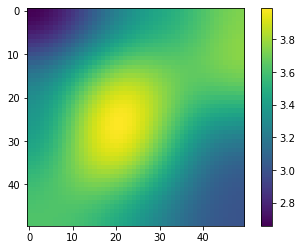

In [578]:
k_cheby = jax.random.uniform(key, minval = -1, maxval = 1, shape = (solver.N, solver.N))
k_cheby = k_cheby.at[0,0].set(3.5)

ii, jj = jnp.meshgrid(np.arange(solver.N), np.arange(solver.N))
r = 2
overlay = jnp.exp(-(ii**2+jj**2) / r**2)

k_cheby = k_cheby * overlay
k = (solver.I @ k_cheby.flatten()).reshape(solver.N, solver.N)

plt.imshow(k)
plt.colorbar()

key, _ = jax.random.split(key)

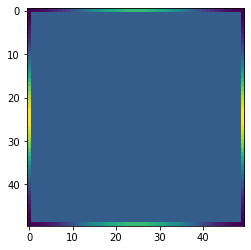

In [579]:
dirichlet = jnp.zeros((solver.N,solver.N))
dirichlet = jnp.cos(xx*yy**2 + xx)


mask = np.ones((solver.N, solver.N))
mask[1:-1,1:-1] = 0
mask = jnp.array(mask)
dirichlet *= mask

plt.imshow(dirichlet)

In [580]:
sol = solver.solve(k_cheby.flatten(), dirichlet)

In [572]:
def get_neumann(solution):
    jx = sol["dx T"].reshape((solver.N,solver.N)) * solution["k"].reshape((solver.N, solver.N))
    jy = sol["dy T"].reshape((solver.N,solver.N)) * solution["k"].reshape((solver.N, solver.N))

    return jx, jy

In [573]:
neumann = get_neumann(sol)

In [574]:
def loss(neumann_target, neumann_input):
    jx_in = neumann_input[0]
    jy_in = neumann_input[1]

    jx_tar = neumann_target[0]
    jy_tar = neumann_target[1]

    dx = jnp.sum((jx_in[0,:] - jx_tar[0,:])**2) + np.sum((jx_in[-1,:] - jx_tar[-1,:])**2)
    dy = jnp.sum((jy_in[:,0] - jy_tar[:,0])**2) + np.sum((jy_in[:,-1] - jy_tar[:,-1])**2)

    return dx + dy

In [581]:
loss(neumann, get_neumann(sol))

Array(121.2801, dtype=float32)